In [1]:
import numpy as np

### A) Write a Python code to implement the Metropolis-Hastings algorithm

In [2]:
def MCMC(log_Posterior,data,initial,step_cov,n_iteration):
    param1=np.array(initial)
    sample=np.array(initial)
    for j in range(n_iteration):
        log_Posterior_i=log_Posterior(data,param1)
        #update the location
        param2=np.random.multivariate_normal(param1,step_cov)
        #find new posterior
        log_Posterior_f=log_Posterior(data,param2)
        # generate a random number between 0 and 1
        rand=np.random.rand()
        if log_Posterior_f-log_Posterior_i>np.log(rand):
            sample=np.vstack((sample,param2))
            param1=param2[:]
        else:
            sample=np.vstack((sample,param1))
    return(sample) 

In [3]:
import pandas as pd

data=pd.read_csv('tweet_counts.csv')

In [4]:
data.head()

,week,count
0,1,39.0
1,2,46.0
2,3,41.0
3,4,42.0
4,5,31.0


In [5]:
k=data['count'].values
w=data['week'].values

In [6]:
Poisson=lambda k,λ : (λ**k)/np.math.factorial(k)*np.exp(-λ)

In [7]:
α = 1/np.mean(k)

In [8]:
def log_posterior(data,param):
    k,w=data
    lamb1,lamb2,W_s=param
    
    P=0
    
    for i in k[w<W_s]:
        P=P+np.log(Poisson(i,lamb1)*α*np.exp(-α*lamb1))
        
    for j in k[w>=W_s]:
        P=P+np.log(Poisson(j,lamb2)*α*np.exp(-α*lamb2))
        
    return(P)

In [9]:
D = MCMC(log_posterior,data=[k,w],initial=[20,20,20],step_cov=[[0.25,0,0],[0,0.25,0],[0,0,0.5]],n_iteration=10000)

In [10]:
D[1:10,:]

array([[20.        , 20.        , 20.        ],
       [20.        , 20.        , 20.        ],
       [21.03932828, 20.37302741, 20.16330299],
       [21.03932828, 20.37302741, 20.16330299],
       [21.00196747, 20.83283029, 20.69100775],
       [21.23452373, 20.73721847, 21.49931916],
       [21.23452373, 20.73721847, 21.49931916],
       [22.00732197, 20.84019021, 20.96075818],
       [22.70740909, 20.83109322, 20.66733691]])

### B) Are the posteriors consistent with those you found in the previous homework?

In [11]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize']=8,6

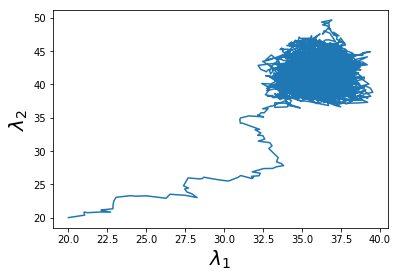

In [12]:
plt.plot(D.T[0],D.T[1])
plt.xlabel("$\lambda_1$",fontsize=20)
plt.ylabel("$\lambda_2$",fontsize=20)
plt.show()

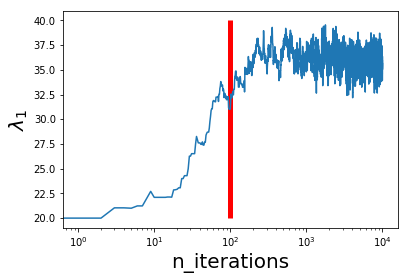

In [13]:
plt.plot(D.T[0])
plt.ylabel("$\lambda_1$",fontsize=20)
plt.xlabel("n_iterations",fontsize=20)
plt.vlines(100,20,40,color='red',linewidth=5)
plt.xscale('log')

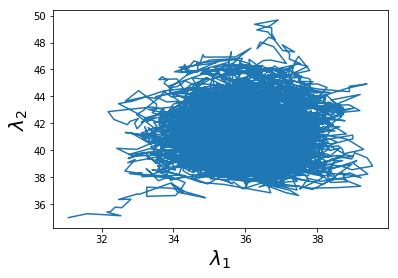

In [14]:
plt.plot(D.T[0][100:],D.T[1][100:])
plt.xlabel("$\lambda_1$",fontsize=20)
plt.ylabel("$\lambda_2$",fontsize=20)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

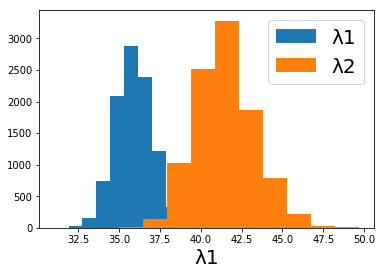

In [15]:
plt.hist(D.T[0][100:],label='λ1')
plt.hist(D.T[1][100:],label='λ2')
plt.xlabel("λ1", fontsize=20)
plt.legend(fontsize=20)
plt.show


In [16]:
print('mean(λ1 is)', np.mean(D.T[0][100:]))
print('std(λ1 is)', np.std(D.T[0][100:]))

mean(λ1 is) 35.90342868683033
std(λ1 is) 1.1046408521537372


In [17]:
print('mean(λ2 is)', np.mean(D.T[1][100:]))
print('std(λ2 is)', np.std(D.T[1][100:]))

mean(λ2 is) 41.48234680934315
std(λ2 is) 1.8116689631141836


In [18]:
print('mean(W_s is)', np.round(np.mean(D.T[2][100:])))

mean(W_s is) 34.0


####  posteriors are consistent with homework #2

### C) As you did in part g of homework 2, find P(( λ1- λ2) > 5)

P(34.8<λ1<37.0)=68.2% (1 standard deviation)
P(39.8<λ2<43.2)=68.2% (1 standard deviation) 

With the assumption that lamb 1 and lamb 2 posterior distributions are gaussian like based on the histogram

They both have similar distributions so their multiplied distribution would be similar as well meaning Bob would have a 68.2% probability that his weekly tweet counts have increased by five at some point.



## Problem 2: K-means Clustering

### a, b) write and implement python code for K-means clustering in euclidean space

In [19]:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import style
import random
import math
import sklearn


style.use('ggplot')

In [20]:
#start with k centers (4 centers)
from sklearn.datasets import make_blobs

X,Y = make_blobs(n_samples=500, cluster_std=0.8,centers=3, n_features=3,random_state=0)

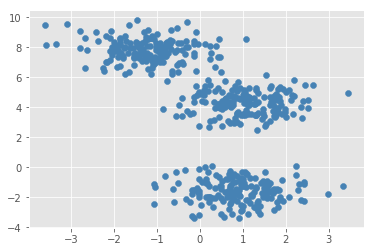

In [32]:
# plot the data
plt.scatter(X[:,0],X[:,1], color = 'steelblue')

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

In [23]:

# build dataframe for holding values, distances, and closest centroids
df = pd.DataFrame({
    'x' : X[:,0],
    'y' : X[:,1]})
df.head()

,x,y
0,0.029140,-2.541718
1,-1.852313,8.584712
2,0.963818,-0.708849
3,-0.687670,8.488246
4,1.867022,-2.120719


In [24]:
#find centroid of each cluster
# centroids[i] = [x, y]

k=3

centroids = {
    i+1: [np.random.randint(-10, 10), np.random.randint(-10, 10)]
    for i in range(k)
}
centroids


{1: [0, -3], 2: [8, 9], 3: [-6, -4]}

In [25]:
def assign(df, centroids):
    
    for i in centroids.keys():
        # sqrt((x1 - x2)^2 + (y1 - y2)^2)
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0]) ** 2
                + (df['y'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    return df

In [26]:

#closest centroids to k centers
df = assign(df, centroids)
print(df.head())

          x         y  distance_from_1  distance_from_2  distance_from_3  \
0  0.029140 -2.541718         0.459208        14.026612         6.202992   
1 -1.852313  8.584712        11.731864         9.861062        13.250596   
2  0.963818 -0.708849         2.485622        11.990397         7.702366   
3 -0.687670  8.488246        11.508809         8.702729        13.571188   
4  1.867022 -2.120719         2.063712        12.699756         8.088370   

   closest  
0        1  
1        2  
2        1  
3        2  
4        1  


### b) Considering 3 clusters, apply your function in part a to the dataset you have created.

In [27]:
# update closest centroid 
def update(k,df):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['x'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['y'])
    return k

while True:
    closest_centroids = df['closest'].copy(deep=True)
    centroids = update(centroids,df)
    df = assign(df, centroids)
    if closest_centroids.equals(df['closest']):
        break

In [28]:
# build dataframe for holding values, distances, and closest centroids
df_c = pd.DataFrame({
    'x' : X[:,0],
    'y' : X[:,1]})
df_c.head()




,x,y
0,0.029140,-2.541718
1,-1.852313,8.584712
2,0.963818,-0.708849
3,-0.687670,8.488246
4,1.867022,-2.120719


In [29]:

k = 3
# centroids[i] = [x, y]
centroids = {
    i+1: [np.random.randint(-5, 5), np.random.randint(-5, 5)]
    for i in range(k)
}
centroids

df_c = assign(df_c, centroids)

while True:
    closest_centroids = df_c['closest'].copy(deep=True)
    centroids = update(centroids,df_c)
    df_c = assign(df_c, centroids)
    if closest_centroids.equals(df_c['closest']):
        break

print(df_c)

            x         y  distance_from_1  distance_from_2  distance_from_3  \
0    0.029140 -2.541718         1.270491         8.577656         1.584480   
1   -1.852313  8.584712        10.148202         3.113303        11.033376   
2    0.963818 -0.708849         0.851187         6.822320         1.329996   
3   -0.687670  8.488246         9.862443         2.530578        10.643564   
4    1.867022 -2.120719         1.700025         8.381891         0.421825   
5   -1.906008  7.334180         8.945684         2.252851         9.867276   
6    1.039453  4.948653         6.301902         1.549622         6.893442   
7   -1.042213 -1.324716         1.410972         7.424698         2.604304   
8    0.840078 -1.471982         0.496022         7.561786         0.795730   
9    0.048575 -0.986797         0.460261         7.023138         1.723244   
10   1.573717 -1.994256         1.382038         8.195228         0.104921   
11  -1.742260  8.032639         9.585436         2.607950       

### c) Explain a method where we can determine optimal number of clusters in K-means algorithm.

We can find the optimal number of clusters using the elbow method. We need to run the algorithm for various numbers of k, i.e.1-10 and calculate the total within-cluster sum of square. Then plot the curve for k and sum of square. We will pick the k value for where the graph begins to bend.

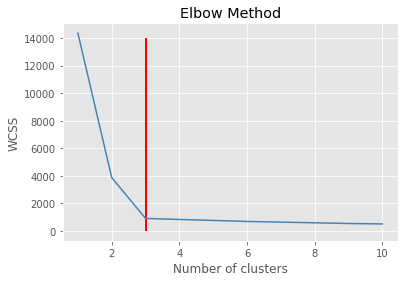

In [31]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss,color='steelblue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.vlines(3,0,14000,color='red',linewidth=2)
plt.show()